In [88]:
# Python modules
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from tqdm import tqdm

# Custom module(s)
from load_data import load_gzip_txt_data

Note that the following cell is the same as in `naive_model.ipynb`.

In [172]:
BASE_PATH = './data/RateBeer/'
MAX_ENTRIES = int(1e6)

# Importing ratings
df = load_gzip_txt_data(
    path=os.path.join(BASE_PATH, "ratings.txt.gz"),
    attributes=["beer_id", "abv", "rating", "user_id"],
    max_entries=MAX_ENTRIES,
)
df["abv"] = df["abv"].astype(float)
df["rating"] = df["rating"].astype(float)
df.dropna(inplace=True)
df['user_id'] = df['user_id'].astype(int)
df['beer_id'] = df['beer_id'].astype(int)

# Importing user data
users = pd.read_csv(
    os.path.join(BASE_PATH, "users.csv"),
)
users['location'] = users['location'].astype(str)

# Merging user data with ratings
df = pd.merge(left=df, right=users, on="user_id", how="left")

# Adding continent
def get_continent(location: str) -> str:
    if not isinstance(location, str): # NOTE: This should never trigger, but we never know...
        return "Other"
    european_countries = [
        "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
        "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
        "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France",
        "Georgia", "Germany", "Gibraltar", "Greece", "Hungary", "Iceland",
        "Ireland", "Italy", "Jersey", "Kazakhstan", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova",
        "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
        "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino",
        "Scotland", "Serbia", "Slovakia", "Slovak Republic", "Slovenia",
        "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "Vatican City",
        "Wales"
    ] # NOTE: This list has been defined in P2 milestone.
    if location in european_countries:
        return "Europe"
    elif location.startswith("United States") or location == 'Canada' or location == 'Mexico':
        return "America"
    else:
        return "Other"
df["continent"] = df["location"].apply(get_continent)

# Importing beers
beers = pd.read_csv(os.path.join(BASE_PATH, "beers.csv"))

# Importing breweries
breweries = pd.read_csv(os.path.join(BASE_PATH, "breweries.csv"))
breweries['continent'] = breweries['location'].apply(get_continent)

# Merging beers and breweries
beers = pd.merge(left=beers, right=breweries, left_on="brewery_id", right_on="id", how="left")
beers['id'] = beers['id'].astype(int)

display(df)

Loading data from:  ./data/RateBeer/ratings.txt.gz


16999997it [00:08, 1897723.34it/s]


,beer_id,abv,rating,user_id,nbr_ratings,user_name,joined,location,continent
0,410549,5.0,2.0,175852,1890.0,Manslow,1.337508e+09,Poland,Europe
1,105273,5.2,1.9,442761,89.0,MAGICuenca91,1.484046e+09,Spain,Europe
2,105273,5.2,1.6,288889,169.0,Sibarh,1.384600e+09,Poland,Europe
3,105273,5.2,1.5,250510,3371.0,fombe89,1.363950e+09,Spain,Europe
4,105273,5.2,1.9,122778,13043.0,kevnic2008,1.296644e+09,Germany,Europe
...,...,...,...,...,...,...,...,...,...
984594,39904,4.9,3.1,19400,23458.0,Papsoe,1.106910e+09,Denmark,Europe
984595,39904,4.9,2.9,5328,35316.0,Ungstrup,1.028714e+09,Denmark,Europe
984596,39904,4.9,2.9,1880,7409.0,motelpogo,1.002103e+09,Czech Republic,Europe
984597,39904,4.9,2.1,832,5207.0,duff,9.889704e+08,Denmark,Europe


Defining some functions.

In [173]:
def get_fit_equation(
        result: scipy.stats._stats_mstats_common.LinregressResult,
        decilams: int = 2
    ) -> str:
    """Returns the equation of the regression line."""
    return f'$y = ({result.slope:.{decilams}f}\\pm{result.stderr:.{decilams}f})x \
    + ({result.intercept:.{decilams}f}\\pm{result.intercept_stderr:.{decilams}f})$'

# Naive model with one-to-one matching

We will now perform a one-to-one matching. We will match one european rating to an americain when they have rated the same beer. In the following, we perform an optimized one-to-one matching (since the number of unique beers is much smaller than the overall size of the dataset). **In fact, this is not true anymore as we look at a large portion of the dataset. To mitigate this, we will only look at the N most popular beers.**

In [187]:
# Taking all beers:
# beer_ids = df["beer_id"].unique()

# OR taking only the most rated beers:
# beer_ids = df["beer_id"].value_counts().index[:2000]
# TODO: See if this does not introduce a new biais (e.g. popular beers are all
# european). To mitigate this, please prefer the method right after.

# OR (better) taking only the most rated beers, half of them being european, half of them being american:
european_beer_indices = beers.query("continent == 'Europe'")['beer_id'].values
american_beer_indices = beers.query("continent == 'America'")['beer_id'].values
reviews_of_european_beers = df.query("beer_id in @european_beer_indices")
reviews_of_american_beers = df.query("beer_id in @american_beer_indices")
most_reviewed_european_beers = reviews_of_european_beers["beer_id"].value_counts().index[:1000]
most_reviewed_american_beers = reviews_of_american_beers["beer_id"].value_counts().index[:1000]
beer_ids = np.concatenate([most_reviewed_european_beers, most_reviewed_american_beers])

# OR taking a random sample of beers:
# beer_ids = df["beer_id"].value_counts().sample(2000).index

matched_rows = []

for beer_id in tqdm(beer_ids):
    american_reviews = df.query("beer_id == @beer_id and continent == 'America'")
    european_reviews = df.query("beer_id == @beer_id and continent == 'Europe'")
    min_review_count = min(len(american_reviews), len(european_reviews))
    if min_review_count == 0:
        continue
    american_indices = american_reviews.sample(min_review_count).index
    european_indices = european_reviews.sample(min_review_count).index
    matched_rows += list(american_indices) + list(european_indices)

matched_df = df.loc[matched_rows]

100%|██████████| 2000/2000 [00:55<00:00, 35.85it/s]


In [189]:
print(f"American reviews: " + str(len(matched_df.query("continent == 'America'"))))
print(f"European reviews: " + str(len(matched_df.query("continent == 'Europe'"))))

print(f"American beers: " + str(len(matched_df.query("beer_id in @american_beer_indices")["beer_id"].unique())))
print(f"European beers: " + str(len(matched_df.query("beer_id in @european_beer_indices")["beer_id"].unique())))

American reviews: 68136
European reviews: 68136
American beers: 983
European beers: 979


Note that the following code is the same as in `naive_model.ipynb`, but here with a one-to-one matching.

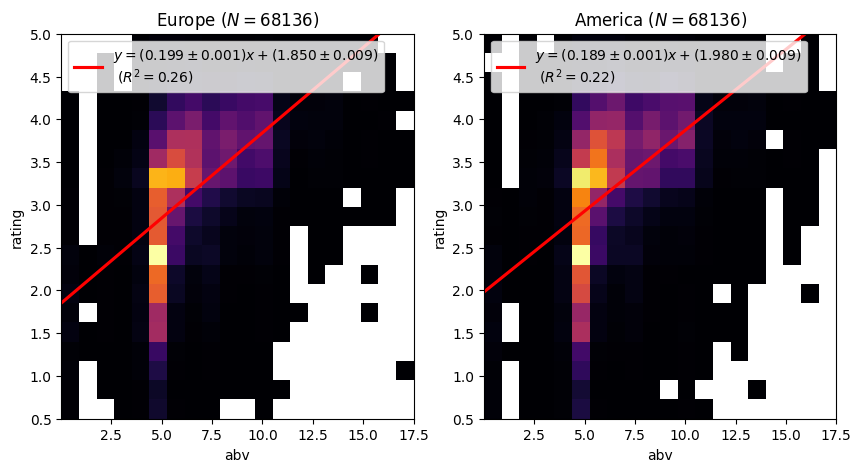

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [190]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

fit_results = []

for continent_index, continent in enumerate(['Europe', 'America']):

    df_ = matched_df.query(f'continent == @continent')

    # Drawing the background histogram
    plt.figure(figsize=(5, 5))
    sns.histplot(
        data=df_,
        x="abv",
        y="rating",
        bins=20, # NOTE: There are only ~50 unique values for ratings.
        cmap="inferno",
        ax=axes[continent_index],
    )

    # Drawing the regression line
    regplot = sns.regplot(
        data=df_,
        x="abv",
        y="rating",
        scatter=False,
        line_kws={'color':'r', 'alpha':1.0},
        ax=axes[continent_index],
    )

    # Computing the regression and some statistics
    x = df_['abv'].values
    y = df_['rating'].values
    result = scipy.stats.linregress(x=x, y=y)
    fit_results.append(result)

    # Finalizing the plot
    legend_text = f'{get_fit_equation(result, 3)}\n ($R^2 = {result.rvalue**2:.2f}$)'
    axes[continent_index].legend([legend_text], loc='upper left')
    axes[continent_index].set(
        xlim=(matched_df['abv'].min(), matched_df['abv'].max()),
        ylim=(matched_df['rating'].min(), matched_df['rating'].max()),
        title=f'{continent} ($N={len(df_)}$)',
    )

plt.show()

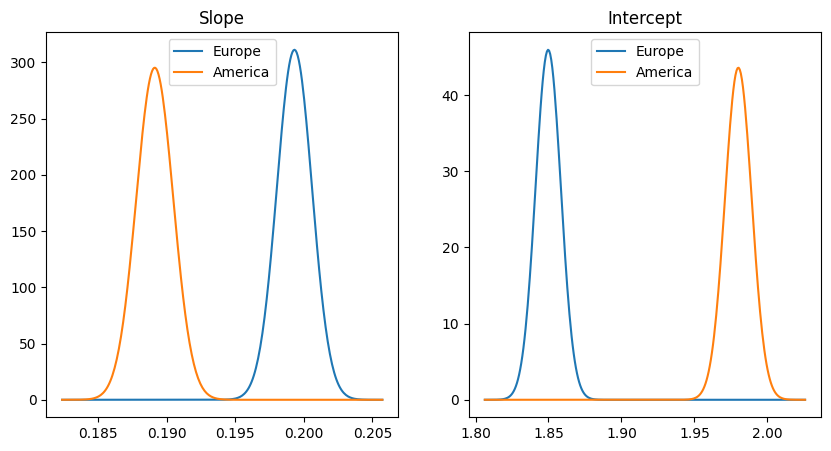

In [191]:
def gaussian(loc: float, scale: float, x: float) -> float:
    """Returns the value of a Gaussian distribution at a given point."""
    return scipy.stats.norm(loc=loc, scale=scale).pdf(x)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

for continent_index, continent in enumerate(['Europe', 'America']):
    result = fit_results[continent_index]

    # Plot the slope informations
    x = np.linspace(
        start=min([result.slope - 5 * result.stderr for result in fit_results]),
        stop=max([result.slope + 5 * result.stderr for result in fit_results]),
        num=300,
    )
    y = gaussian(loc=result.slope, scale=result.stderr, x=x)
    axes[0].plot(x, y, label=continent)
    
    # Plot the intercept informations
    x = np.linspace(
        start=min([result.intercept - 5 * result.intercept_stderr for result in fit_results]),
        stop=max([result.intercept + 5 * result.intercept_stderr for result in fit_results]),
        num=300,
    )
    y = gaussian(loc=result.intercept, scale=result.intercept_stderr, x=x)
    axes[1].plot(x, y, label=continent)

axes[0].set_title('Slope')
axes[1].set_title('Intercept')
axes[0].legend()
axes[1].legend()


As in `naive_model.ipynb`, we draw both lines.

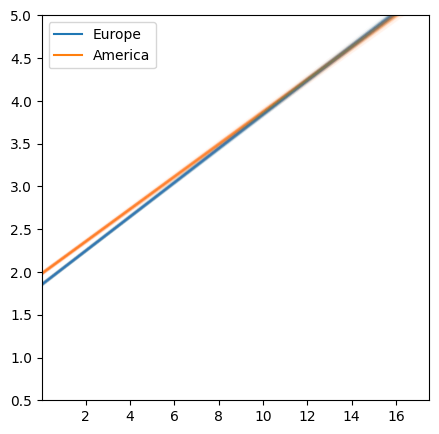

In [192]:
plt.figure(figsize=(5, 5))

for i in range(100):

    slope = fit_results[0].slope + np.random.normal(loc=0, scale=fit_results[0].stderr)
    intercept = fit_results[0].intercept + np.random.normal(loc=0, scale=fit_results[0].intercept_stderr)
    x = np.linspace(0, 20, 2)
    y = slope*x + intercept
    plt.plot(x, y, color='tab:blue', alpha=0.02)

    slope = fit_results[1].slope + np.random.normal(loc=0, scale=fit_results[0].stderr)
    intercept = fit_results[1].intercept + np.random.normal(loc=0, scale=fit_results[0].intercept_stderr)
    x = np.linspace(0, 20, 2)
    y = slope*x + intercept
    plt.plot(x, y, color='tab:orange', alpha=0.02)

plt.plot(0,1, color='tab:blue', label='Europe') # NOTE: Dummy plot for legend.
plt.plot(0,1, color='tab:orange', label='America') # NOTE: Dummy plot for legend.
plt.xlim(matched_df['abv'].min(), matched_df['abv'].max())
plt.ylim(matched_df['rating'].min(), matched_df['rating'].max())
plt.legend()
plt.show()